In [1]:
import mesa_reader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Union
from pathlib import Path
from pprint import pprint
from matplotlib.patches import Circle, Ellipse, Polygon
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.ndimage import correlate1d

In [2]:
def read_mesa_file(file: Union[Path, str]):
    """A simple file reader that can read a mesa .data file or a .mod model file.
    It returns all the values inside those files as an dictionary. If values
    are part of a table, they will be arrays.
    
    Inputs: A file path
    """
    if isinstance(file, str):
        file = Path(file)
    dic = {}
    with file.open('r') as fil:
        if file.suffix == ".mod":
            fil.readline()
            fil.readline()
            fil.readline()
            fil.readline()
            line = fil.readline().split()
            while len(line) > 0:
                # print(line)
                if line[1].count("'") > 0:  # Strings
                    dic[line[0]] = line[1]
                elif line[1].count('.') == 1:  # Floats, D or E
                    dic[line[0]] = float(line[1].replace('D', 'E'))
                elif line[1].isdigit():  # Ints
                    dic[line[0]] = line[1]
                line = fil.readline().split()
            keys = ["i"] + fil.readline().split()
        elif file.suffix == ".data":
                
            fil.readline()
            keys = fil.readline().split()
            vals = fil.readline().split()
            for k, v in zip(keys, vals):
                if v.count(".") == 1:
                    dic[k] = float(v)
                elif v.isdigit():
                    dic[k] = int(v)
                elif v.count(".") == 2:
                    dic[k] = v
                else:
                    dic[k] = None
            fil.readline()
            fil.readline()
            keys = fil.readline().split()
        # print(keys)
        line = fil.readline()
        while len(line.split()) > 0:
            for i, v in enumerate(line.split()):
                if v.count(".") == 1:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(float(v.replace('D', 'E')))
                    else:
                        dic[keys[i]] = [float(v.replace('D', 'E'))]
                elif v.isdigit():
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(int(v))
                    else:
                        dic[keys[i]] = [int(v)]
                elif v.count(".") == 2:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(v)
                    else:
                        dic[keys[i]] = [v]
                else:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(None)
                    else:
                        dic[keys[i]] = [None]
                    keys[i]
            line = fil.readline()
        for key, item in dic.items():
            if isinstance(item, list):
                dic[key] = np.array(item)
    return dic

In [3]:
def planck(lamda, Teff):
    lhs = 2 * 6.626e-34 * 2.9979e8 * 2.9979e8 / lamda**5
    exp = 6.626e-34 * 2.9979e8 / lamda / 1.3806e-23 / Teff
    result = lhs / (np.exp(exp) - 1)
    return result

def color_temp(Teff):
    lamdas = np.arange(300, 800, 10) * 1e-9
    fluxes = planck(lamdas, Teff)
    blue = np.sum(fluxes[(lamdas > 400e-9) & (lamdas < 490e-9)])
    green = np.sum(fluxes[(lamdas > 485e-9) & (lamdas < 570e-9)])
    red = np.sum(fluxes[(lamdas > 565e-9) & (lamdas < 660e-9)])
    color = np.array([red, green, blue])
    color = color / np.max(color)
    return color

In [4]:
first = mesa_reader.MesaData("final_model_00.30.mod")
first.data

<bound method MesaData.data of <mesa_reader.MesaData object at 0x7f48d69c6a00>>

In [5]:
here = Path()
print(here.absolute())
models = []
imodels = []
mod_sorter = []
for i, fil in enumerate(here.glob("profile_final_*.data")):
    models.append(read_mesa_file(fil))
    mod_sorter.append(models[i]["initial_mass"])
    if models[i]["initial_mass"] == 1.0:
        solar_ind = i
sorter = np.array(mod_sorter).argsort()
models = np.array(models)[sorter]
solar_ind = sorter[i]
mdl = read_mesa_file(fil)
pprint(mdl.keys())
print(f"Solar Model is at Index {solar_ind}")

mod_sorter = []
for i, fil in enumerate(here.glob("LOGS/profile_*1.data")):
    imodels.append(read_mesa_file(fil))
    mod_sorter.append(imodels[i]["initial_mass"])
sorter = np.array(mod_sorter).argsort()
imodels = np.array(imodels)[sorter]



/home/dgatlin/Documents/2022/astr_565/assignment_16.1
dict_keys(['model_number', 'num_zones', 'initial_mass', 'initial_z', 'star_age', 'time_step', 'Teff', 'photosphere_L', 'photosphere_r', 'center_eta', 'center_h1', 'center_he3', 'center_he4', 'center_c12', 'center_n14', 'center_o16', 'center_ne20', 'star_mass', 'star_mdot', 'star_mass_h1', 'star_mass_he3', 'star_mass_he4', 'star_mass_c12', 'star_mass_n14', 'star_mass_o16', 'star_mass_ne20', 'he_core_mass', 'co_core_mass', 'fe_core_mass', 'neutron_rich_core_mass', 'dynamic_time', 'kh_timescale', 'nuc_timescale', 'power_nuc_burn', 'power_h_burn', 'power_he_burn', 'power_neu', 'burn_min1', 'burn_min2', 'time_seconds', 'version_number', 'compiler', 'build', 'MESA_SDK_version', 'math_backend', 'date', 'msun', 'rsun', 'lsun', 'zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H', 'y_mass_fraction_He', 'z_mass_fraction_metals', 'gradT', 'grada', 'gradr', 'gradL', 'luminosity', 'pp', 'cno', 'mu'])
Solar Model is at Index 6


In [6]:
def set_lumen_ticks(x, y):
    first_try = f"{x:.2e}"
    lbrace = '{'
    rbrace = '}'
    base, ex = first_try.replace('+', '').split('e')
    ex = ex.lstrip('0')
    ex = ex.replace("-0", "-")
    if "1.0" in base:
        base = ""
    else:
        base += r"\times"
    latex_str = f"${base}10^{lbrace}{ex}{rbrace}L_\odot$"
    if ex == "":
        latex_str = "$L_\odot$"
    elif ex == "1":
        latex_str = f"$10L_\odot$"
    return latex_str


def set_age_ticks(x, y):
    first_try = f"{x:.0e}"
    lbrace = '{'
    rbrace = '}'
    base, ex = first_try.split('e+')
    ex = ex.lstrip('0')
    if "1" in base:
        base = ""
    else:
        base += r"\times"
    latex_str = f"${base}10^{lbrace}{ex}{rbrace}\mathrm{lbrace}Gyr{rbrace}$"
    return latex_str
    

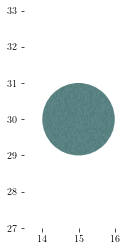

In [7]:
def plot_point(ax, x_val, y_val, rad, model):
    """A possibly useful tool for plotting a granulated circle. Doesn't work
    well on log-log plots, you'll end up with teardrops"""
    high_color = color_temp(model["Teff"])
    low_color = color_temp(0.6 * model["Teff"])
    color_path = {'red':   [(0.0,  0.0, high_color[0]),
                            (1.0,  low_color[0], 1.0)],

                  'green': [(0.0,  0.0, high_color[1]),
                            (1.0,  low_color[1], 1.0)],

                  'blue':  [(0.0,  0.0, high_color[1]),
                            (1.0,  low_color[1], 1.0)]}
    custom_map = LinearSegmentedColormap("This Star", color_path)
    # width =  np.exp(model["lnR"][-1]) / np.exp(models[solar_ind]["lnR"][-1]) * 1000
    circle = Circle((x_val, y_val), rad,
                    facecolor="none", edgecolor="none")
    ax.add_patch(circle)
    bg = plt.imshow(np.random.random((100, 100)), origin="lower",
                   cmap=custom_map, interpolation="nearest",
                   extent=[x_val * 0.9, x_val * 1.1, y_val * 0.9, y_val * 1.1])
    bg.set_clip_path(circle)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(False)
ax.set_facecolor((1, 1, 1))
x_range = (30000, 3000)
y_range = (1e-2, 1e5)
# width = 1000
# height = width * x_range / y_range * 0.7
rad = 1
plot_point(ax,
           15, 30, rad,
        #    mdl["Teff"], mdl["L"][-1] / models[solar_ind]["L"][-1],
           mdl)
# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

## HR Diagram

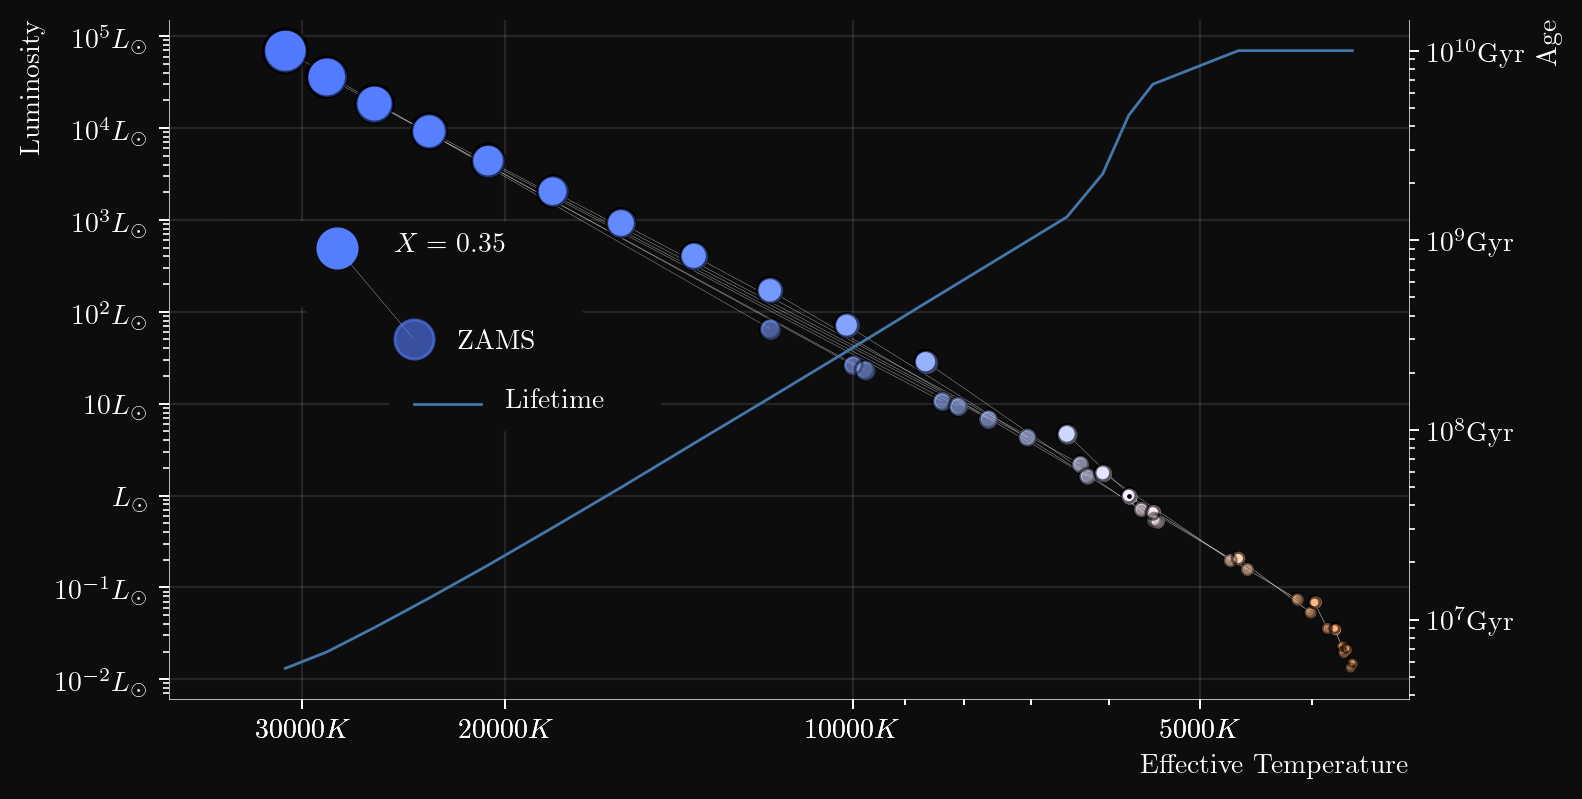

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), dpi=200)
teffs = []
lifetimes = []
for i, model in enumerate(models):
    teffs.append(model["Teff"])
    lifetimes.append(model["star_age"])
    x_val = model["Teff"]
    y_val = model["photosphere_L"] / models[solar_ind]["photosphere_L"]
    ax.scatter(model["Teff"], model["photosphere_L"] / models[solar_ind]["photosphere_L"],
               color=color_temp(model["Teff"]),
               s=model["photosphere_r"] / models[solar_ind]["photosphere_r"]
               * 22,
               zorder=10)
    ax.scatter(imodels[i]["Teff"], imodels[i]["photosphere_L"] / models[solar_ind]["photosphere_L"],
               color=color_temp(imodels[i]["Teff"]),
               s=imodels[i]["photosphere_r"] / models[solar_ind]["photosphere_r"]
               * 22, alpha=0.6,
               zorder=10)

    ax.arrow(imodels[i]["Teff"],
              imodels[i]["photosphere_L"] / models[solar_ind]["photosphere_L"],
              model["Teff"] - imodels[i]["Teff"],
              (model["photosphere_L"] - imodels[i]["photosphere_L"])
              / models[solar_ind]["photosphere_L"],
              color="white", linewidth=0.1, alpha=0.5, 
              )
    
    for j in range(10):
        ax.scatter(model["Teff"], model["photosphere_L"] / models[solar_ind]["photosphere_L"],
                   color='k', alpha=0.15 * (11 - j)/11, facecolor="none", edgecolors='k',
                   s=model["photosphere_r"] / models[solar_ind]["photosphere_r"]
                   * (28 - np.log(j + 1)), zorder=15)
        ax.scatter(imodels[i]["Teff"], imodels[i]["photosphere_L"] / models[solar_ind]["photosphere_L"],
                   color='k', alpha=0.6 * 0.15 * (11 - j)/11, facecolor="none", edgecolors='k',
                   s=imodels[i]["photosphere_r"] / models[solar_ind]["photosphere_r"]
                   * (28 - np.log(j + 1)), zorder=15)
        
x0 = 28000
y0 = 500
ax.scatter(x0, y0, alpha=1,
           s=model["photosphere_r"] / models[solar_ind]["photosphere_r"] * 22,
           color=color_temp(25000), zorder=20)
ax.scatter(x0 - 4000, y0 * 0.1, alpha=0.6,
           s=model["photosphere_r"] / models[solar_ind]["photosphere_r"] * 22,
           color=color_temp(25000), zorder=20)
for j in range(10):
    ax.scatter(x0, y0,
               color='k', alpha=0.15 * (11 - j)/11, facecolor="none",
               edgecolors='k',
               s=model["photosphere_r"] / models[solar_ind]["photosphere_r"]
               * (28 - np.log(j + 1)), zorder=15)
    ax.scatter(x0 - 4000, y0 * 0.1,
           color='k', alpha=0.6 * 0.15 * (11 - j)/11, facecolor="none", edgecolors='k',
           s=model["photosphere_r"] / models[solar_ind]["photosphere_r"]
           * (28 - np.log(j + 1)), zorder=15)
ax.arrow(x0, y0, -4000, y0 * 0.1 - y0, color="white", linewidth=0.1, alpha=0.5, zorder=16)
ax.annotate(r"$X=0.35$", (x0-3000, y0 - 50), color="white", zorder=25)
ax.annotate("ZAMS", (x0-6000, y0 * 0.1 - 10), color="white", zorder=25)
ax.plot([24000, 21000], [10, 10], color=[0.267, 0.467, 0.667], zorder=20)
ax.annotate("Lifetime", (20000, 9), color="white", zorder=25)
paral = Polygon([[x0 + 7000, y0 + 470], [x0 - 8000, y0 + 470],
                 [x0 - 14000, 5], [x0-4000, 5]], True,
                     facecolor=[0.05, 0.05, 0.05], zorder=15)
ax.add_patch(paral)

ax.scatter(models[solar_ind]["Teff"], 1, color="k", s=0.5, zorder=20)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, alpha=0.1)
ax.invert_xaxis()
ax.set_frame_on(True)
ax.set_xlabel(r"Effective Temperature")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
# ax.xaxis.tick_bottom.set_color("white")
# ax.yaxis.label.set_color("white")
ax.set_ylabel(r"Luminosity")
fig.set_facecolor([0.05, 0.05, 0.05])
# ax.set_facecolor([1, 1, 1])
ax.set_facecolor([0.05, 0.05, 0.05])
ax.tick_params(axis="both", which="both", colors="white")
ax.spines["bottom"].set_color("white")
ax.spines["bottom"].set_linewidth(0.25)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("white")
ax.spines["left"].set_linewidth(0.25)
ax.spines["left"].set_visible(True)
ax.xaxis.set_major_formatter("${x:.0f}K$")
ax.xaxis.set_ticks([3000, 5000, 10000, 20000, 30000])
ax.xaxis.set_visible(True)
ax.yaxis.set_major_formatter(set_lumen_ticks)
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_facecolor([0.05, 0.05, 0.05])
ax2.tick_params(axis="both", which="both", colors="white")
ax2.set_yscale("log")
ax2.spines["right"].set_color("white")
ax2.spines["right"].set_linewidth(0.25)
ax2.spines["right"].set_visible(True)
ax2.xaxis.set_major_formatter("${x:.0f}K$")
ax2.xaxis.set_visible(True)
ax2.yaxis.set_major_formatter(set_age_ticks)
ax2.plot(teffs, lifetimes)
ax2.set_ylabel("Age", color="white")
fig.savefig("hr_diagram")


## Mass Plot


In [9]:
def gen_blackbody_cmap(t0, t1, n_steps=100):
    cdict = {"red": [(0.0, 0.0, 0.0)], "green": [(0.0, 0.0, 0.0)],
             "blue": [(0.0, 0.0, 0.0)]}
    for step, temp in zip(np.linspace(0.01, 1, n_steps),
                          np.linspace(t0, t1, n_steps)):
        color = color_temp(temp)
        cdict["red"].append((step, color[0], color[0]))
        cdict["green"].append((step, color[1], color[1]))
        cdict["blue"].append((step, color[2], color[2]))
    blackbody_cmap = LinearSegmentedColormap("Blackbody", cdict)
    return blackbody_cmap

In [10]:
def mass_ticks(x, y):
    tick = f"{x:.1f}"
    if tick[-2:] == ".0":
        tick = f"{x:.0f}"
    return tick
bbody_cmap = gen_blackbody_cmap(2000, 10000, 500)

In [11]:
conv = model["gradT"] - model["grada"]
np.sum(conv > 0), conv.size

(290, 1057)

In [12]:
model["grada"]

array([0.24982797, 0.24963127, 0.24943171, ..., 0.28727768, 0.28727747,
       0.28727729])

840890.0918956382
829835.4331524089
733471.8649807776
577015.8072234518
637189.0852760714
505962.03265512164
309755.2810187654
86921.63729870607
484.47325248331634
1.117715835291097
1.1631478426296227
1.1862078109735776
1.2044393978229322
1.242261676063953
1.2944605151674868
1.3645176971418005
1.4638259570955603
1.586607031311146
1.7345171195354858
1.9222019274230249
0.2548
7527.661128631658
[[1.39616244e+00 1.30840296e+00 1.25933296e+00 ... 3.09630713e+03
  7.52766113e+03 3.01755666e-02]
 [6.19673858e-01 5.69352001e-01 5.41128130e-01 ... 2.24962804e+03
  5.58422579e+03 2.84199321e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.13580050e+03
  3.23014224e+03 2.17179634e-02]
 ...
 [1.58672576e+00 1.47070511e+00 1.40550246e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.73463989e+00 1.61473273e+00 1.54667704e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.92232934e+00 1.79791346e+00 1.72755587e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


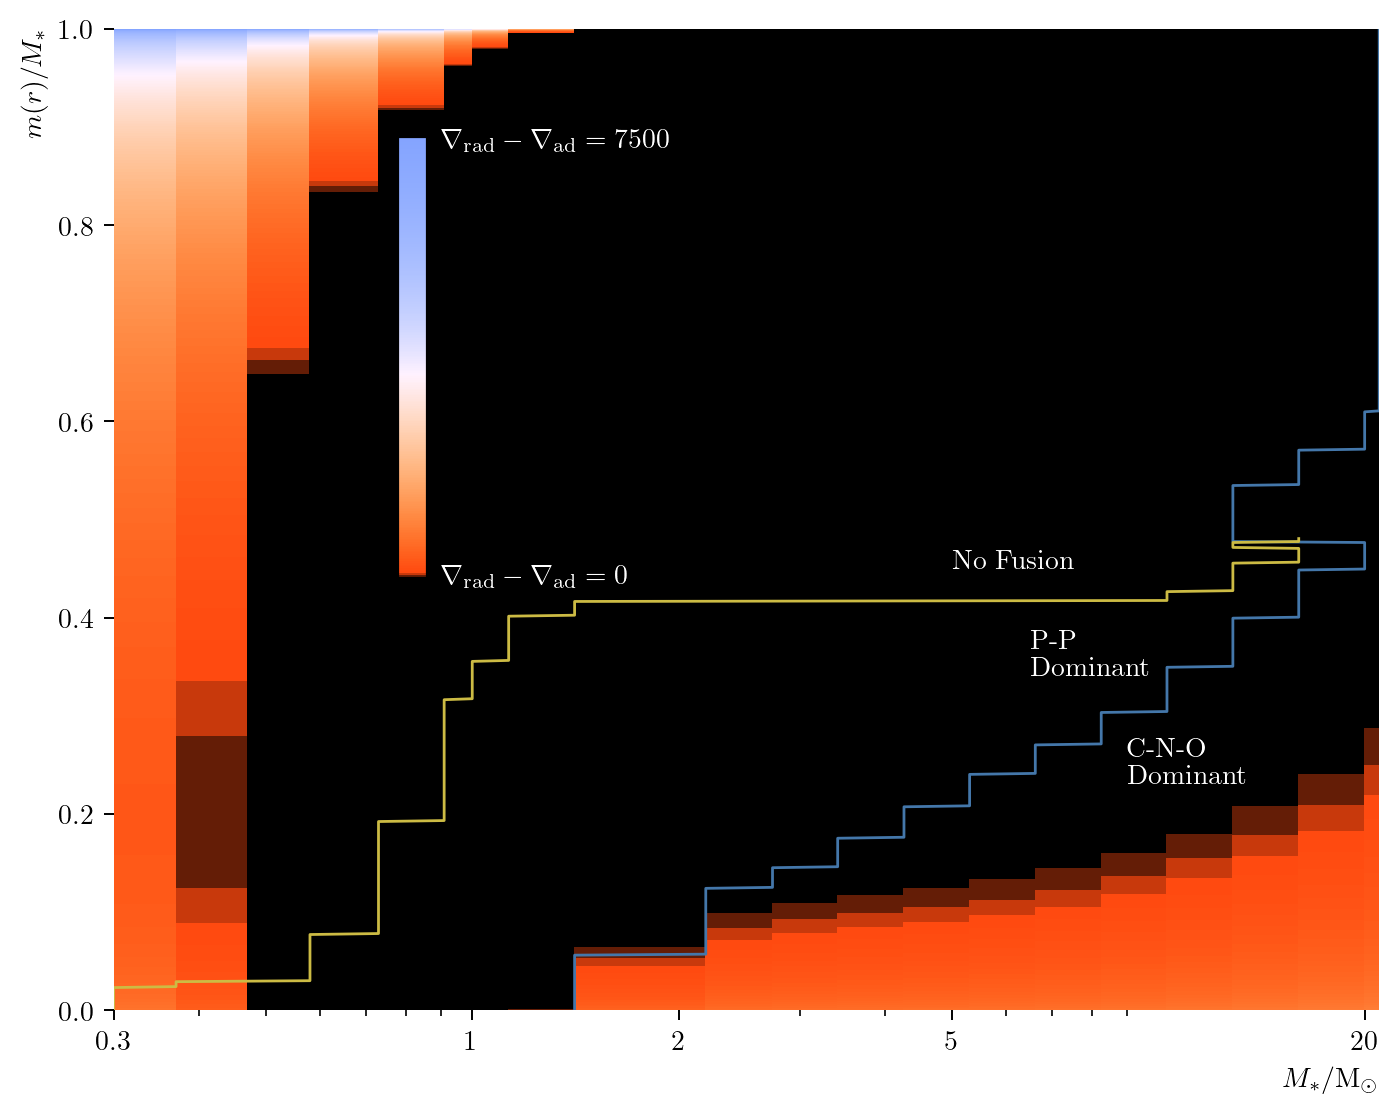

In [13]:
img = []
masses = []
lengths = []
convects = []
pps = []
cnos = []
mass_pro = np.linspace(0, 1, 1000)
many_masses = np.geomspace(0.3, 20, 1000)
for model in models:
    masses.append(model["initial_mass"])
    norm_mass_pro = model["mass"] / model["initial_mass"]
    convectivity = model["gradr"] - model["grada"]
    print(convectivity.max())
    pp = model["pp"]
    cno = model["cno"]
    lengths.append(model["num_zones"])
    interper = interp1d(norm_mass_pro, convectivity, bounds_error=False,
                        fill_value="extrapolate")
    interp_pp = interp1d(norm_mass_pro, pp, bounds_error=False,
                        fill_value="extrapolate")
    interp_cno = interp1d(norm_mass_pro, cno, bounds_error=False,
                        fill_value="extrapolate")
    convects.append(interper(mass_pro))
    pps.append(interp_pp(mass_pro))
    cnos.append(interp_cno(mass_pro))

masses = np.array(masses)
sorter = masses.argsort()
masses = masses[sorter]
convects = np.array(convects)
convects = convects[sorter]
pps = np.array(pps)
cnos = np.array(cnos)
pps = pps[sorter]
cnos = cnos[sorter]
convects[convects < 0] = 0

filt = (cnos + pps) < 1
cnos[filt] = np.nan
pps[filt] = np.nan
cno_dominant = ((cnos - pps) > 0).astype(float)
pp_dominant = ((pps - cnos) > 0).astype(float)
cno_dominant[~cno_dominant.astype(bool)] = np.nan
pp_dominant[~pp_dominant.astype(bool)] = np.nan

pp_boundary = []
cno_boundary = []
for cno, pp in zip(cno_dominant.T, pp_dominant.T):
    cno_masses = masses[~np.isnan(cno)]
    pp_masses = masses[~np.isnan(pp)]
    if pp_masses.size == 0:
        pp_boundary.append(np.nan)
    else:
        pp_boundary.append(pp_masses.min())
    if cno_masses.size == 0:
        cno_boundary.append(np.nan)
    else:
        cno_boundary.append(cno_masses.min())
        
cno_boundary = np.array(cno_boundary)
pp_boundary = np.array(pp_boundary)
cno_boundary[np.isnan(cno_boundary)] = 21

img = np.array(img)
print(np.sum(convects > 0) / convects.size)
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8, 6.5))
X, Y = np.meshgrid(np.append(masses, 21), np.append(mass_pro, 1.01))
im = ax.pcolor(X, Y, np.log10(1 + convects.T),
            #    extent=[masses[0], masses[-1], 0, 1], interpolation="nearest",
            #    aspect="auto", origin="lower"
               cmap=bbody_cmap)
ax.plot(cno_boundary, mass_pro)
ax.plot(pp_boundary, mass_pro, color=[0.8, 0.733, 0.267])
ax.grid(False)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.3, 21)
ax.set_ylim(0, 1.0)
fig.set_facecolor("white")
ax.xaxis.set_major_formatter(mass_ticks)
ax.xaxis.set_ticks([0.3, 1, 2, 5, 20])
cbar = fig.colorbar(im, ticks=[], shrink=0.45, aspect=15, location="left",
                    anchor=(0, 0.8), pad=-0.28)
ax.set_xlabel(r"$M_*/\mathrm{M_\odot}$")
ax.set_ylabel(r"$m(r)/M_*$")
ax.annotate(r"$\nabla_\mathrm{rad} - \nabla_{\mathrm{ad}}=0$", (0.9, 0.435), c="white",
            zorder=5)
ax.annotate(r"$\nabla_\mathrm{rad} - \nabla_{\mathrm{ad}}=7500$", (0.9, 0.88), c="white",
            zorder=5)
ax.annotate("P-P\nDominant", (6.5, 0.34), color="white")
ax.annotate("C-N-O\nDominant", (9., 0.23), color="white")
ax.annotate("No Fusion", (5, 0.45), color="white")
fig.subplots_adjust(left=0.2)
fig.savefig("m_heatmap.png", dpi=400)
print(convects.max())
print(convects)

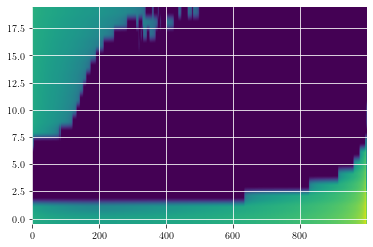

In [14]:
plt.imshow(np.log(1 + convects * 1000000), aspect="auto")

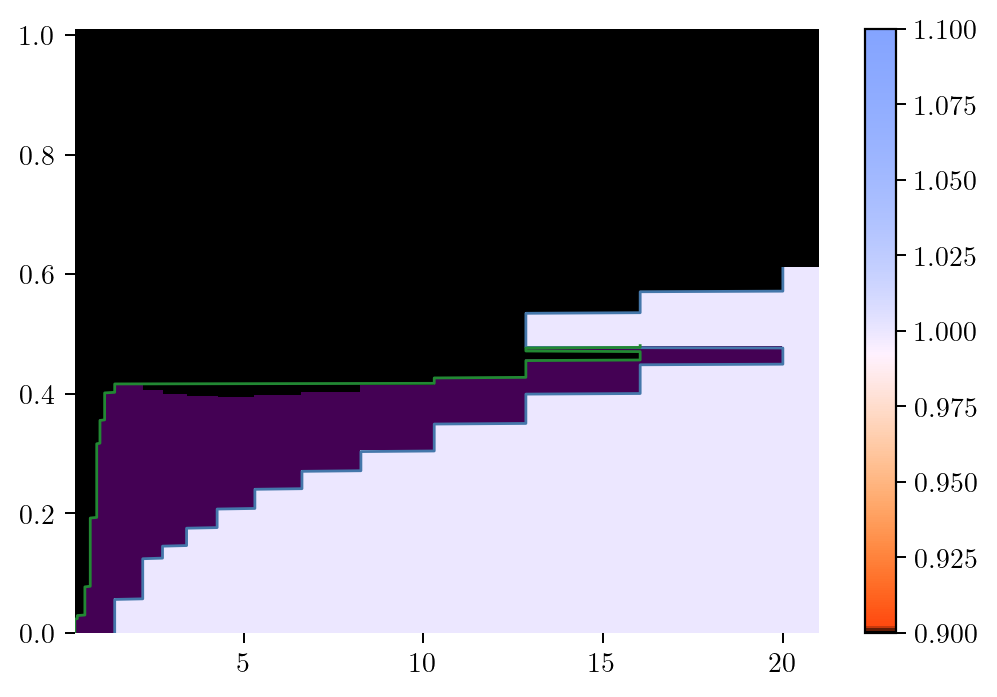

In [15]:
filt = (cnos + pps) < 1
cnos[filt] = np.nan
pps[filt] = np.nan
cno_dominant = ((cnos - pps) > 0).astype(float)
pp_dominant = ((pps - cnos) > 0).astype(float)
cno_dominant[~cno_dominant.astype(bool)] = np.nan
pp_dominant[~pp_dominant.astype(bool)] = np.nan

pp_boundary = []
cno_boundary = []
for cno, pp in zip(cno_dominant.T, pp_dominant.T):
    cno_masses = masses[~np.isnan(cno)]
    pp_masses = masses[~np.isnan(pp)]
    if pp_masses.size == 0:
        pp_boundary.append(np.nan)
    else:
        pp_boundary.append(pp_masses.min())
    if cno_masses.size == 0:
        cno_boundary.append(np.nan)
    else:
        cno_boundary.append(cno_masses.min())
        
c_boundary = np.array(cno_boundary)
pp_boundary = np.array(pp_boundary)
    
fig, ax = plt.subplots(1, 1, dpi=200)
X, Y = np.meshgrid(np.append(masses, 21), np.append(mass_pro, 1.01))
ax.pcolor(X, Y, pp_dominant.T - 1, cmap="viridis")
im = ax.pcolor(X, Y, cno_dominant.T, cmap=bbody_cmap,)
ax.plot(c_boundary, mass_pro)
ax.plot(pp_boundary, mass_pro)
ax.set_facecolor([0,0,0])
fig.colorbar(im)
# ax.set_xscale("log")
# ax.set_ylim(0, 1)

## Radius Plot

840890.0918956382
829835.4331524089
733471.8649807776
577015.8072234518
637189.0852760714
505962.03265512164
309755.2810187654
86921.63729870607
484.47325248331634
1.117715835291097
1.1631478426296227
1.1862078109735776
1.2044393978229322
1.242261676063953
1.2944605151674868
1.3645176971418005
1.4638259570955603
1.586607031311146
1.7345171195354858
1.9222019274230249
835839.1833999818


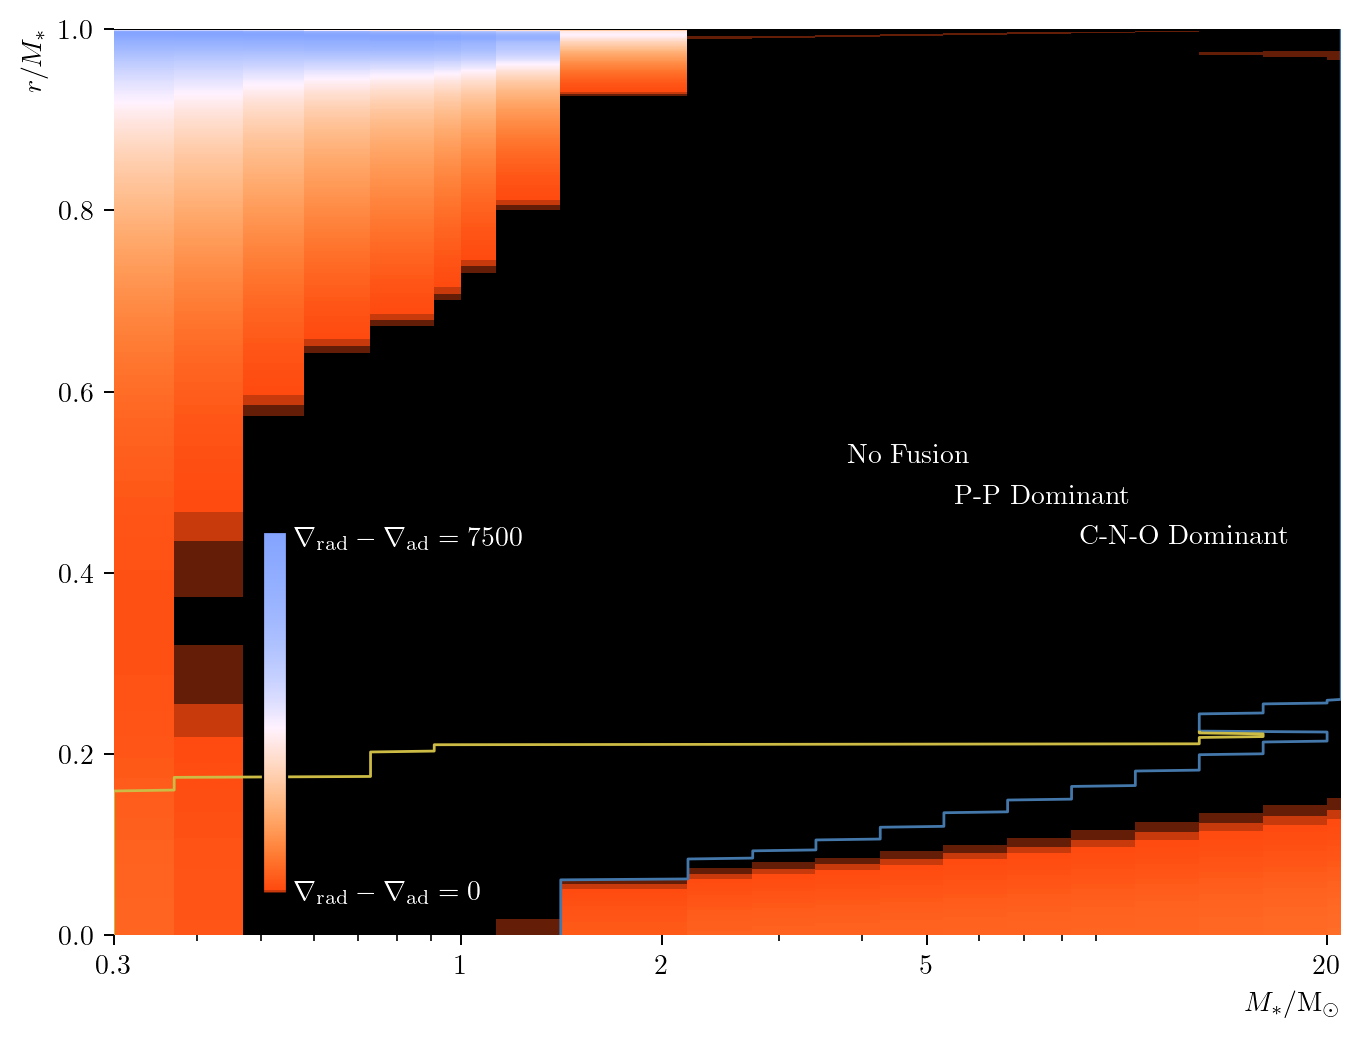

In [16]:
img = []
masses = []
lengths = []
convects = []
pps = []
cnos = []
rad_pro = np.linspace(0, 1, 1000)
for model in models:
    masses.append(model["initial_mass"])
    norm_rad_pro = 10**model["logR"] / model["photosphere_r"]
    convectivity = model["gradr"] - model["grada"]
    print(convectivity.max())
    pp = model["pp"]
    cno = model["cno"]
    lengths.append(model["num_zones"])
    interper = interp1d(norm_rad_pro, convectivity, bounds_error=False,
                        fill_value="extrapolate")
    interp_pp = interp1d(norm_rad_pro, pp, bounds_error=False,
                        fill_value="extrapolate")
    interp_cno = interp1d(norm_rad_pro, cno, bounds_error=False,
                        fill_value="extrapolate")
    convects.append(interper(rad_pro))
    pps.append(interp_pp(rad_pro))
    cnos.append(interp_cno(rad_pro))

masses = np.array(masses)
sorter = masses.argsort()
masses = masses[sorter]
convects = np.array(convects)
convects = convects[sorter]
pps = np.array(pps)
cnos = np.array(cnos)
pps = pps[sorter]
cnos = cnos[sorter]
convects[convects < 0] = 0

filt = (cnos + pps) < 1
cnos[filt] = np.nan
pps[filt] = np.nan
cno_dominant = ((cnos - pps) > 0).astype(float)
pp_dominant = ((pps - cnos) > 0).astype(float)
cno_dominant[~cno_dominant.astype(bool)] = np.nan
pp_dominant[~pp_dominant.astype(bool)] = np.nan

pp_boundary = []
cno_boundary = []
for cno, pp in zip(cno_dominant.T, pp_dominant.T):
    cno_masses = masses[~np.isnan(cno)]
    pp_masses = masses[~np.isnan(pp)]
    if pp_masses.size == 0:
        pp_boundary.append(np.nan)
    else:
        pp_boundary.append(pp_masses.min())
    if cno_masses.size == 0:
        cno_boundary.append(np.nan)
    else:
        cno_boundary.append(cno_masses.min())
        
cno_boundary = np.array(cno_boundary)
pp_boundary = np.array(pp_boundary)
cno_boundary[np.isnan(cno_boundary)] = 21

img = np.array(img)

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8, 6))
X, Y = np.meshgrid(np.append(masses, 21), np.append(rad_pro, 1.01))
im = ax.pcolor(X, Y, np.log10(1 + convects.T),
            #    extent=[masses[0], masses[-1], 0, 1], interpolation="nearest",
            #    aspect="auto", origin="lower"
               cmap=bbody_cmap)

ax.plot(cno_boundary, mass_pro)
ax.plot(pp_boundary, mass_pro, color=[0.8, 0.733, 0.267])
ax.grid(False)
# ax.set_yscale("log")
fig.set_facecolor("white")
ax.set_xscale("log")
ax.set_xlim(0.3, 21)
ax.set_ylim(0, 1.0)
ax.xaxis.set_major_formatter(mass_ticks)
ax.xaxis.set_ticks([0.3, 1, 2, 5, 20])
cbar = fig.colorbar(im, ticks=[], shrink=0.4, aspect=15, location="left",
                    pad=-0.14, anchor=(1, 0.075))
ax.set_xlabel(r"$M_*/\mathrm{M_\odot}$")
ax.set_ylabel(r"$r/M_*$")
ax.annotate(r"$\nabla_\mathrm{rad} - \nabla_{\mathrm{ad}}=0$", (0.56, 0.04), c="white",
            zorder=5)
ax.annotate(r"$\nabla_\mathrm{rad} - \nabla_{\mathrm{ad}}=7500$", (0.56, 0.43), c="white",
            zorder=5)
ax.annotate("P-P Dominant", (5.5, 0.475), color="white")
ax.annotate("C-N-O Dominant", (8.5, 0.431), color="white")
ax.annotate("No Fusion", (3.8, 0.522), color="white")
fig.savefig("r_heatmap.png", dpi=400)
print(convects.max())
